In [1]:
# https://www.youtube.com/watch?v=nyY460O9E38
from IPython.display import clear_output

In [3]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.layers import Input, Flatten, RepeatVector, Conv1D, MaxPooling1D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [5]:
# Загрузка данных о цене золота из YAHOO
#@title Функция загрузки данных (ЗАПУСТИТЕ ЭТОТ КОД)
def load_gold_data(start_date, end_date):
    """
    Функция для загрузки данных о цене золота с Yahoo Finance.

    Аргументы:
    start_date -- дата начала загрузки данных (формат 'YYYY-MM-DD')
    end_date -- дата окончания загрузки данных (формат 'YYYY-MM-DD')

    Возвращает:
    data -- DataFrame с данными о цене золота
    """
    data = yf.download('GC=F', start=start_date, end=end_date)
    data.reset_index(inplace=True)
    return data

In [11]:
# Загрузка данных о цене золота
start_date = "2000-08-30" # начальная дата
end_date = "2024-05-20" # конечная дата
gold_data = load_gold_data(start_date, end_date) # Загружаем данные с помощью функции загрузки
gold_data # выводим таблицу данных

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,GC=F,GC=F,GC=F,GC=F,GC=F,GC=F
0,2000-08-30 00:00:00+00:00,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,2000-08-31 00:00:00+00:00,278.299988,278.299988,278.299988,274.799988,274.799988,0
2,2000-09-01 00:00:00+00:00,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,2000-09-05 00:00:00+00:00,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,2000-09-06 00:00:00+00:00,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...,...
5945,2024-05-13 00:00:00+00:00,2336.100098,2336.100098,2358.300049,2336.100098,2358.300049,14
5946,2024-05-14 00:00:00+00:00,2353.399902,2353.399902,2358.000000,2336.000000,2336.000000,6
5947,2024-05-15 00:00:00+00:00,2388.699951,2388.699951,2388.699951,2356.000000,2361.600098,29


In [15]:
#@title Функция визуализации данных (ЗАПУСТИТЕ ЭТОТ КОД)
def plot_gold_data(data):
    """
    Функция для визуализации данных о цене золота.

    Аргументы:
    data -- DataFrame с данными о цене золота
    """
    plt.figure(figsize=(15, 6))
    plt.plot(data['Date'], data['Close'], label='Цена закрытия')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия (USD)')
    plt.title('Цена закрытия золота за указанный период')
    plt.legend()
    plt.show()

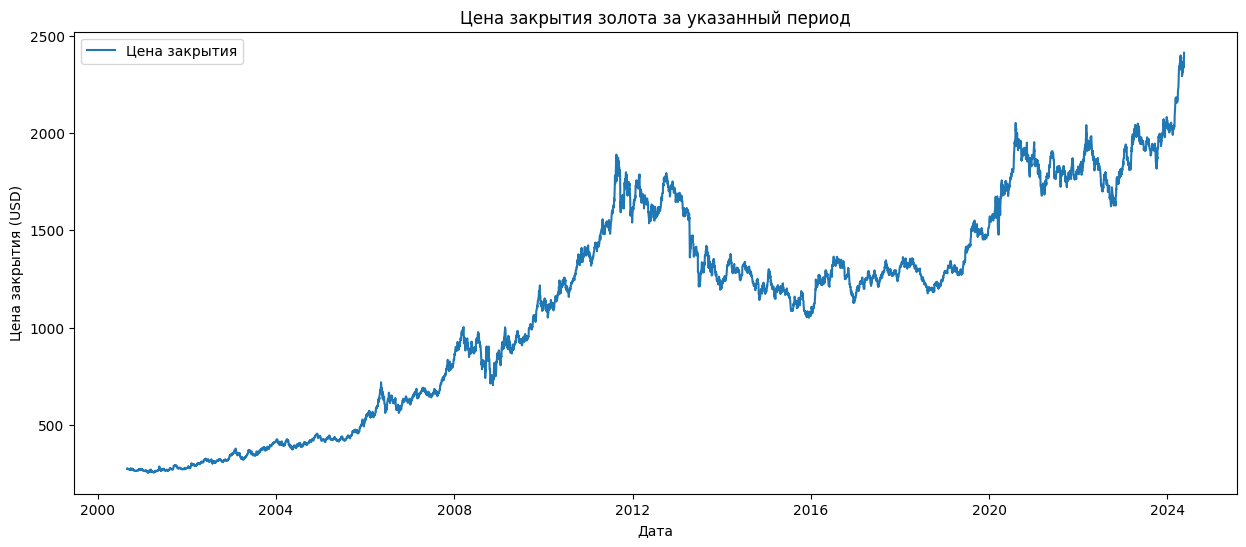

In [17]:
# Визуализация данных по цене золота
plot_gold_data(gold_data)

In [19]:
#@title Функция предобработки данных (ЗАПУСТИТЕ ЭТОТ КОД)
def preprocess_gold_data(gold_data, step_in_the_last):
    # Предобработка данных
    gold_data['Return'] = gold_data['Adj Close'].pct_change()
    gold_data.dropna(inplace=True)
    for i in range(1, step_in_the_last + 1):
        indicator_name = 'Close_chng_%d' % (i)
        gold_data[indicator_name] = gold_data['Adj Close'].pct_change(i)

    # Определение тренда для каждого шага
    for i in range(1, step_in_the_last + 1):
        indicator_name = 'Close_chng_%d' % (i)
        indicator_name_new = 'Y_%d' % (i)
        gold_data[indicator_name_new] = np.where(gold_data[indicator_name] > 0.01, 1,
                                                 np.where(gold_data[indicator_name] < -0.01, -1, 0))

    # Удаление столбцов с изменением цены
    for i in range(1, step_in_the_last + 1):
        indicator_name = 'Close_chng_%d' % (i)
        del gold_data[indicator_name]

    # Оставляем только столбец с закрытием цены и метки тренда
    data = gold_data[['Adj Close'] + ['Y_%d' % i for i in range(1, step_in_the_last + 1)]]
    data.dropna(inplace=True)

    # Масштабирование данных
    xScaler = StandardScaler()
    xScaler.fit(data[['Adj Close']])
    data[['Adj Close']] = xScaler.transform(data[['Adj Close']])
    # Очистка вывода ячейки
    clear_output()

    return data

In [21]:
# Определяем параметры и предобрабатываем данные
step_in_the_last = 50   # количество вспомогательных дней в прошлое для определения тренда
n_steps = 10            # количество дней одного шага для подачи в модель
forvard_lag = 1         # количество дней для прогноза в будущее
preprocessed_data = preprocess_gold_data(gold_data, step_in_the_last) # Загружаем функцию предобработки данных
preprocessed_data       # Выводим данные

Price,Adj Close,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,...,Y_41,Y_42,Y_43,Y_44,Y_45,Y_46,Y_47,Y_48,Y_49,Y_50
Ticker,GC=F,,,,,,,,,,...,,,,,,,,,,
1,-1.559454,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.561847,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.564056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.567002,0,-1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-1.567370,0,0,-1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,2.229004,-1,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5946,2.260854,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5947,2.325842,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [23]:
#@title Функция создания тренировочной и проверочной выборок (ЗАПУСТИТЕ ЭТОТ КОД)
def split_sequence(sequence, labels, n_steps, forvard_lag):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        end_iy = end_ix + forvard_lag
        if end_iy > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], labels[end_ix:end_iy]
        X.append(seq_x)
        y.append(seq_y[-1])  # Используем только последнюю метку из последовательности для текущего набора признаков
    return np.array(X), np.array(y)

def prepare_data(data, n_test, n_steps, forvard_lag):
    indicator_name = 'Y_%d' % (step_in_the_last)
    data_Y = data[indicator_name]
    categorical_labels = to_categorical(data_Y, num_classes=3)  # Учитываем 3 класса

    # Удаление столбца Y_50 из признаков X
    data_X = data.drop(columns=[indicator_name])

    xTrain = data_X[:-n_test-n_steps]
    xTest = data_X[-n_test:]
    yTrain = categorical_labels[:-n_test-n_steps].squeeze()  # Исправление формы меток
    yTest = categorical_labels[-n_test:].squeeze()  # Исправление формы меток

    xTrain, yTrain = split_sequence(xTrain.values, yTrain, n_steps, forvard_lag)
    xTest, yTest = split_sequence(xTest.values, yTest, n_steps, forvard_lag)

    return xTrain, xTest, yTrain, yTest

In [25]:
# Задаем количество дней для тестовой выборки и разделяем данные
n_test = 375
xTrain, xTest, yTrain, yTest = prepare_data(preprocessed_data, n_test, n_steps, forvard_lag)

In [27]:
# Формы получившихся выборок
print("Форма xTrain:", xTrain.shape)
print("Форма xTest:", xTest.shape)
print("Форма yTrain:", yTrain.shape)
print("Форма yTest:", yTest.shape)

Форма xTrain: (5554, 10, 50)
Форма xTest: (365, 10, 50)
Форма yTrain: (5554, 3)
Форма yTest: (365, 3)


In [29]:
#@title Функция для обучения модели (ЗАПУСТИТЕ ЭТОТ КОД)
def build_and_train_model(xTrain, yTrain, xTest, yTest, n_steps):
    input_layer = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
    x = Flatten()(input_layer)
    x = RepeatVector(4)(x)
    x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(n_steps*100, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(3, activation='softmax')(x)  # 3 класса тренда
    model = Model(input_layer, x)

    model.compile(optimizer=Adam(learning_rate=5e-05), loss='categorical_crossentropy', metrics=['accuracy'])

    # Обучение модели
    history = model.fit(xTrain, yTrain, epochs=10, verbose=1, validation_data=(xTest, yTest))

    # Визуализация результатов обучения
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    return model, history

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6952 - loss: 0.7408 - val_accuracy: 0.8548 - val_loss: 0.3616
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8418 - loss: 0.4007 - val_accuracy: 0.8849 - val_loss: 0.2680
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8605 - loss: 0.3395 - val_accuracy: 0.8932 - val_loss: 0.2402
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8755 - loss: 0.3083 - val_accuracy: 0.9096 - val_loss: 0.2205
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8867 - loss: 0.2767 - val_accuracy: 0.9096 - val_loss: 0.2181
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9011 - loss: 0.2670 - val_accuracy: 0.9178 - val_loss: 0.2049
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9064 - loss: 0.2487 - val_accuracy: 0.9151 - val_loss: 0.2054
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9103 - loss: 0.2473 - val_acc

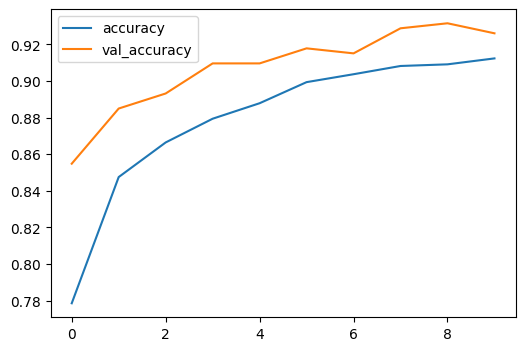

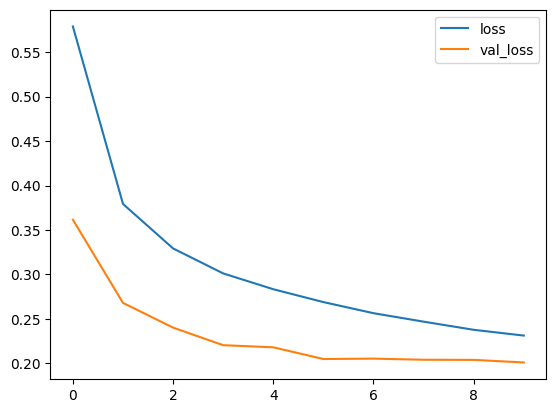

In [31]:
# Тренировка модели
model, history = build_and_train_model(xTrain, yTrain, xTest, yTest, n_steps)

In [35]:
# Предсказание и оценка модели
#@title Функции для предсказания и оценки модели
def prepare_test_data(xTest, yTest, n_test_days):
    x_test = xTest[-n_test_days:]
    y_test_org = yTest[-n_test_days:]
    return x_test, y_test_org

def predict_and_evaluate(model, x_test, y_test_org):
    true_answer = 0
    predictions = []

    for i in range(len(x_test)):   # Выбираю пример
        x = x_test[i]
        x = np.expand_dims(x, axis=0)
        prediction = model.predict(x) # Распознаём наш пример
        prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

        predictions.append(prediction)

        if prediction == np.argmax(y_test_org[i]):
            true_answer += 1

        print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
              '\t====>', y_test_org[i])

    print('Правильных ответов:', true_answer)
    print('Ошибочных ответов:', len(x_test) - true_answer)

In [37]:
# Предсказание и оценка модели на данных о цене золота
n_test_days = 365 # количество дней для предсказания
x_test, y_test_org = prepare_test_data(xTest, yTest, n_test_days) # преподготовка тестовых данных
predict_and_evaluate(model, x_test, y_test_org) # предсказание тренда на золото по дням

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Index: 0 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Index: 1 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Index: 2 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Index: 3 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Index: 4 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Index: 5 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Index: 6 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Index: 7 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Index: 8 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Index: 9 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Index: 10 	Prediction: 1 Real: 1 	====> [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 